## The pp chain reation
The equation for the rate is shown below:

$$
R(T_9) = C \cdot T_9^{\alpha} \cdot \exp(-b \cdot T_9^{-1/3})
$$

The constants for the rate of pp chain reaction comes from the article "THERMONUCLEAR REACTION RATES V*" 

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Avogadro constant
NA = 6.022e23

# Reaction rate parameterized function（unit：cm^3/mol/s，For a two-body reaction, the actual rate constant needs to be divided by NA）
def rate_pp(T9):
    # p + p -> d + e+ + ν
    return 4.01e-15 * T9**(-2/3) * np.exp(-3.380 * T9**(-1/3)) 

def rate_dp(T9):
    # d + p -> ³He + γ
    return 2.24e3 * T9**(-2/3) * np.exp(-3.720 * T9**(-1/3)) 

def rate_33(T9):
    # ³He + ³He -> ⁴He + 2p
    return 6.04e10 * T9**(-2/3) * np.exp(-12.276 * T9**(-1/3)) 

def rate_34(T9):
    # ³He + ⁴He -> ⁷Be + γ
    return 5.61e6 * (T9 / (1 + 4.95e-2 * T9))**(5/6) / (T9 ** (2/3)) * np.exp(-12.826 / ((T9 / (1 + 4.95e-2 * T9)) ** (1/3)))

def rate_li7p(T9):
    # ⁷Li + p -> 2⁴He
    return 1.096e9 * T9**(-2/3) * np.exp(-8.472 * T9**(-1/3))

def rate_be7p(T9):
    # ⁷Be + p -> ⁸B + γ
    return 3.11e5 * T9**(-2/3) * np.exp(-10.262 * T9**(-1/3))

# other rates
lambda_be7e = 1e-7          # ⁷Be + e- -> ⁷Li + ν  （electron capture）
lambda_b8_decay = np.log(2)/0.77   # ⁸B decay，the half life is about 0.77 s


def T9A(T9):
    """calculate corrected temperature T9A"""
    return T9 / (1 + 4.95e-2 * T9)

def reaction_rate(T9):
    """Calcualte reaction rate (sigma * v)"""
    T9A_value = T9A(T9)
    rate = 5.61e6 * (T9A_value**5.6) / (T9**3.2) * np.exp(-12.826 / (T9A_value**1.3))
    return rate

def lambda_rate(T9):
    """Calculate rate constant λ = N_A * reaction_rate"""
    return N_A * reaction_rate(T9)

# example
#T9_sample = 1.5  # assume T9 = 1.5
#lambda_value = lambda_rate(T9_sample)
#print(f"At T9 = {T9_sample}, lambda rate = {lambda_value:.4e} s^-1")

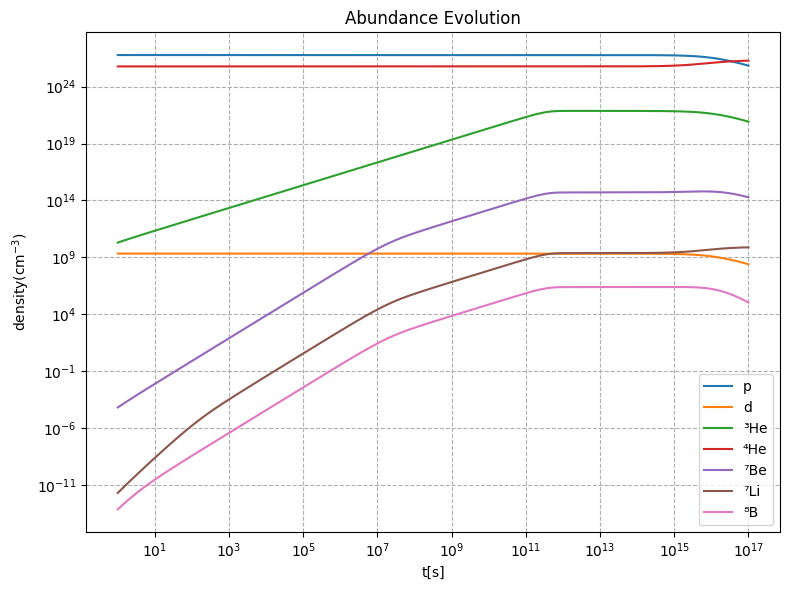

final time t = 1.000e+17 seconds' abundance:
   p: 6.995e+25 cm^-3
   d: 2.485e+08 cm^-3
 ³He: 8.391e+20 cm^-3
 ⁴He: 1.925e+26 cm^-3
 ⁷Be: 1.902e+14 cm^-3
 ⁷Li: 7.540e+09 cm^-3
  ⁸B: 1.065e+05 cm^-3


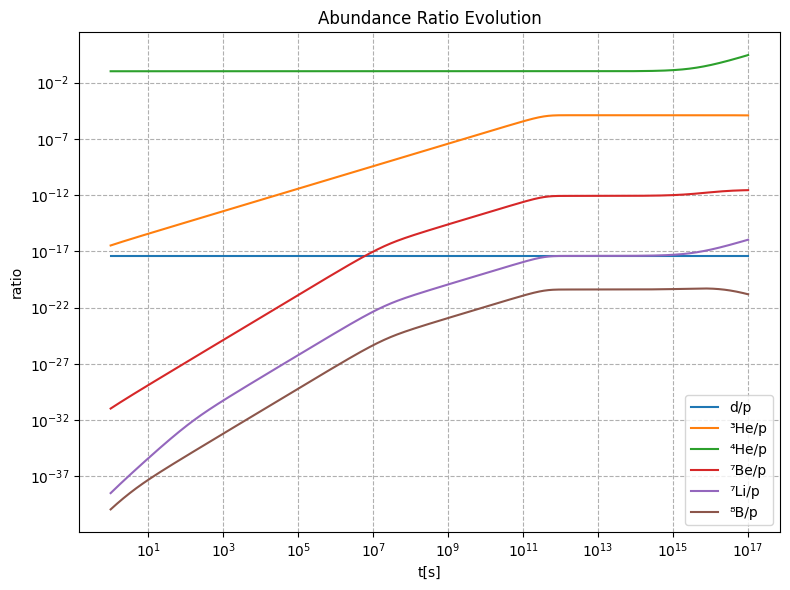

In [2]:
# determine the temperature 
T = 1.5e7         # K
T9 = T / 1e9      # unit is 10^9 K

# The number density of hydrogen in the initial core [cm^-3]
nH0 = 6e26

# According to the formula given in the literature, the two-body reaction rate is converted to cm^3/s（divide by NA）
lambda_pp   = rate_pp(T9)   / NA    # p+p
lambda_dp   = rate_dp(T9)   / NA    # d+p
lambda_33   = rate_33(T9)   / NA    # ³He+³He
lambda_34   = rate_34(T9)   / NA    # ³He+⁴He
lambda_li7p = rate_li7p(T9) / NA    # ⁷Li+p
lambda_be7p = rate_be7p(T9) / NA    # ⁷Be+p

# elements included in the reaction：
# y[0] : p (hydrogen)
# y[1] : d (deuterium)
# y[2] : ³He
# y[3] : ⁴He
# y[4] : ⁷Be
# y[5] : ⁷Li
# y[6] : ⁸B

# initial condition： p and ⁴He dominate at the beginning（take ⁴He/n_p ~ 0.1），take 0 for other intermediate product initial value(normalised)
y0 = [ nH0,       # p
       0.0,       # d
       0.0,       # ³He
       0.1*nH0,   # ⁴He
       0.0,       # ⁷Be
       0.0,       # ⁷Li
       0.0 ]      # ⁸B

# define ODE（unit：cm^-3/s）
def dY_dt(t, y):
    # the density for each element
    p   = y[0]
    d   = y[1]
    He3 = y[2]
    He4 = y[3]
    Be7 = y[4]
    Li7 = y[5]
    B8  = y[6]
    
    # reaction rate（cm^-3 s^-1）
    # p+p reaction：Note that since two identical particles are multiplied by a symmetry factor of 0.5
    r1 = 0.5 * lambda_pp * p * p         # p + p -> d + e+ + ν
    r2 = lambda_dp * d * p                # d + p -> ³He + γ
    r3 = 0.5 * lambda_33 * He3 * He3       # ³He + ³He -> ⁴He + 2p
    r4 = lambda_34 * He3 * He4             # ³He + ⁴He -> ⁷Be + γ
    r5 = lambda_be7e * Be7                 # ⁷Be + e- -> ⁷Li + ν
    r6 = lambda_li7p * Li7 * p             # ⁷Li + p -> 2⁴He
    r7 = lambda_be7p * Be7 * p             # ⁷Be + p -> ⁸B + γ
    r8 = lambda_b8_decay * B8              # ⁸B decay -> 2⁴He
    
    # the ODE for reaction 
    dp_dt   = -2*r1 - r2 - r6 - r7 + 2*r3
    dd_dt   = + r1 - r2
    dHe3_dt = + r2 - 2*r3 - r4
    dHe4_dt = + r3 + 2*r6 + 2*r8 - r4
    dBe7_dt = + r4 - r5 - r7
    dLi7_dt = + r5 - r6
    dB8_dt  = + r7 - r8

    return [dp_dt, dd_dt, dHe3_dt, dHe4_dt, dBe7_dt, dLi7_dt, dB8_dt]

# integrate、data analysis、plot
if __name__ == '__main__':
    # the time interval for integrating（unit：s）
    t_start = 0.0
    t_end   = 1e17
    # To better show the change, log time
    n_points = 1000
    t_eval = np.logspace(np.log10(1e0), np.log10(t_end), n_points)
    
    sol = solve_ivp(dY_dt, [t_start, t_end], y0, method='BDF', t_eval=t_eval, rtol=1e-8, atol=1e-20)
    
    if not sol.success:
        raise RuntimeError("ODE Solution failure！")
    
    # get the result
    t = sol.t   # time（s）
    y = sol.y   # Number density of each species, row corresponding species (same order as y0)
    
    # Calculate the ratio of each species to p (note: p also changes over time, here take n_i/n_p
    ratio_d   = y[1] / y[0]
    ratio_He3 = y[2] / y[0]
    ratio_He4 = y[3] / y[0]
    ratio_Be7 = y[4] / y[0]
    ratio_Li7 = y[5] / y[0]
    ratio_B8  = y[6] / y[0]
    
    # plot the graph
    plt.figure(figsize=(8, 6))
    plt.loglog(t, y[0], label='p')
    plt.loglog(t, y[1], label='d')
    plt.loglog(t, y[2], label='³He')
    plt.loglog(t, y[3], label='⁴He')
    plt.loglog(t, y[4], label='⁷Be')
    plt.loglog(t, y[5], label='⁷Li')
    plt.loglog(t, y[6], label='⁸B')
    plt.xlabel("t[s]")
    plt.ylabel("density(cm$^{-3}$)")
    plt.title("Abundance Evolution")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    
    # print abundance finally
    species = ['p', 'd', '³He', '⁴He', '⁷Be', '⁷Li', '⁸B']
    print("final time t = {:.3e} seconds' abundance:".format(t[-1]))
    for i, sp in enumerate(species):
        print("{:>4}: {:.3e} cm^-3".format(sp, y[i, -1]))
    
    # Calculate the ratio of each species to p and plot
    ratio_d   = y[1] / y[0]
    ratio_He3 = y[2] / y[0]
    ratio_He4 = y[3] / y[0]
    ratio_Be7 = y[4] / y[0]
    ratio_Li7 = y[5] / y[0]
    ratio_B8  = y[6] / y[0]
    
    plt.figure(figsize=(8, 6))
    plt.loglog(t, ratio_d, label='d/p')
    plt.loglog(t, ratio_He3, label='³He/p')
    plt.loglog(t, ratio_He4, label='⁴He/p')
    plt.loglog(t, ratio_Be7, label='⁷Be/p')
    plt.loglog(t, ratio_Li7, label='⁷Li/p')
    plt.loglog(t, ratio_B8, label='⁸B/p')
    
    plt.xlabel("t[s]")
    plt.ylabel("ratio")
    plt.title("Abundance Ratio Evolution")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()